In [2]:
''''
Link to Github repository:

https://github.com/Daniilab/DSCI510_Final_Project.git

'''

from psaw import PushshiftAPI                               #Importing wrapper library for reddit(Pushshift)
import datetime as dt                                       #Importing library for date management
import pandas as pd                                         #Importing library for data manipulation in python
import matplotlib.pyplot as plt      
import yfinance as yf                    #Importing library for creating interactive visualizations in Python
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf
import textwrap
import numpy as np


api = PushshiftAPI()  #establishing the API and parameters



KeyboardInterrupt: 

In [3]:
before = int(dt.datetime(2021,2,26,0,0).timestamp()) #.timestamp() converts the date to epoch time 
after = int(dt.datetime(2021,1,1,0,0).timestamp())

subreddit="wallstreetbets"
limit=25000


In [29]:
#Creating a stock price data frame

def Stock_Price_Data(ticker, after, before):
    data = yf.download(ticker,after,before)

    stock_price_df = pd.DataFrame(data)
    stock_price_df = stock_price_df.reset_index() #making Date a column rather than an index
    stock_price_df['Date'] = stock_price_df['Date'].astype(str) #convert Date to string format to prepare for merge
    
    return stock_price_df


In [30]:
stockpriceGme = Stock_Price_Data("GME", after, before)

[*********************100%***********************]  1 of 1 completed


# Sentiment & Score Analysis


In [31]:
#setting up for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
#sia.polarity_scores("great observation, captain obvious!")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daniilabbruzzese/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}

In [32]:
#creating a data frame for score & sentiment analysis

def Reddit_Comment_Data2 (word_to_check, subbreddit, limit, before, after):

    comments = api.search_comments(q = word_to_check, subreddit= subreddit, limit= limit, before=before, after=after)
    comments_list=[]

    for comment in comments:
        comments_list.append(
            {"score": comment.score, "Date":comment.created, "comment_text": comment.body}
        )

    comments_df=pd.DataFrame(comments_list)

    comments_df["Date"] = pd.to_datetime(comments_df["Date"], unit="s").dt.date


    # create a new column with the sentiment of each row
    comments_df['Sentiment'] = comments_df['comment_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    comments_df['Weighted Sentiment'] = comments_df['Sentiment']*comments_df['score']

    
    #creating sentiment df that is grouped by date
    grouped_weighted_sentiment_df = comments_df.groupby(by="Date")["Weighted Sentiment"].sum()
    pd.DataFrame(grouped_weighted_sentiment_df)

    grouped_weighted_sentiment_df = grouped_weighted_sentiment_df.reset_index()

    grouped_weighted_sentiment_df['Date'] = grouped_weighted_sentiment_df['Date'].astype(str)

    #creating score df that is grouped by date
    grouped_score_df = comments_df.groupby(by="Date")["score"].sum()
    pd.DataFrame(grouped_score_df)

    grouped_score_df = grouped_score_df.reset_index()

    grouped_score_df['Date'] = grouped_score_df['Date'].astype(str)


    #merging the two data frames
    score_sentiment_grouped_df = pd.merge(grouped_score_df, grouped_weighted_sentiment_df, on='Date')


    return score_sentiment_grouped_df

    #pd.set_option("display.max_colwidth", -1) #this is how to view full comments_test text

  

In [33]:
r2 = Reddit_Comment_Data2("gme to the moon", subreddit, limit, before, after)

/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [50]:
mergedData2 = pd.merge(r2, stockpriceGme, on='Date')

mergedData2['Pct Change of Score'] = mergedData2['score'].pct_change()*100
mergedData2['Pct Change of Closing Price'] = mergedData2['Close'].pct_change()*100
mergedData2.rename(columns={'Weighted Sentiment': 'Weighted_Sentiment'}, inplace=True)
mergedData2['Pct Change of WS'] = mergedData2['Weighted_Sentiment'].pct_change()*100


del mergedData2["Adj Close"]
del mergedData2["Open"]
del mergedData2["High"]
del mergedData2["Low"]

mergedData2




,Date,score,Weighted_Sentiment,Close,Volume,Pct Change of Score,Pct Change of Closing Price,Pct Change of WS
0,2021-01-14,1562,224.8169,9.977500,374869600,NaN,NaN,NaN
1,2021-01-15,6618,1596.7118,8.875000,187465600,323.687580,-11.049862,610.227656
2,2021-01-19,3669,691.3683,9.840000,298887600,-44.560290,10.873241,-56.700495
3,2021-01-20,2832,96.6273,9.780000,133887200,-22.812756,-0.609760,-86.023759
4,2021-01-21,2896,262.8113,10.757500,224867600,2.259887,9.994887,171.984522
5,2021-01-22,3994,-212.6734,16.252501,788631600,37.914365,51.080651,-180.922472
6,2021-01-27,1017,-92.1668,86.877502,373586800,-74.536805,434.548528,-56.662751
7,2021-01-28,70273,1611.6025,48.400002,235263200,6809.832842,-44.289373,-1848.571611
8,2021-01-29,91827,20585.7533,81.250000,202264400,30.671809,67.871896,1177.346821
9,2021-02-01,52328,5446.0527,56.250000,149528800,-43.014582,-30.769231,-73.544555


# Linear Regression

In [64]:
#regression analysis

# run a linear regression with 'Weighted_Sentiment' as the predictor and 'Close' as the response
model1 = smf.ols('Close ~ score', mergedData2)
model2 = smf.ols('Close ~ Weighted_Sentiment', mergedData2)

results1 = model1.fit()
results2 = model2.fit()

# display the results
print(results1.summary())
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     18.57
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           0.000240
Time:                        17:30:58   Log-Likelihood:                -108.70
No. Observations:                  26   AIC:                             221.4
Df Residuals:                      24   BIC:                             223.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7891      3.675      4.025      0.0

# Regression Visualizations

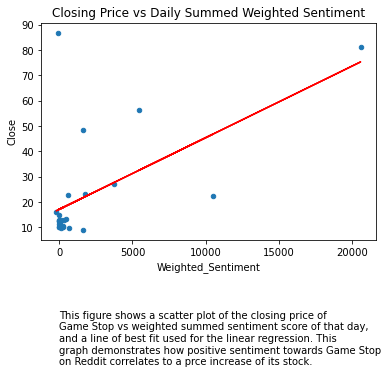

In [117]:
# Linear regression - Weighted Sentiment

# create a scatter plot of the data
mergedData2.plot(kind='scatter', x='Weighted_Sentiment', y='Close')

# fit a linear regression model to the data
slope, intercept = np.polyfit(mergedData2['Weighted_Sentiment'], mergedData2['Close'], 1)

# add a regression line to the scatter plot
plt.plot(mergedData2['Weighted_Sentiment'], slope*mergedData2['Weighted_Sentiment'] + intercept, color='red')

plt.title("Closing Price vs Daily Summed Weighted Sentiment")

# plt.text(-15, -20, "This figure shows a scatter plot of the closing price of Game Stop vs weighted summed daily sentiment score, and a line of best fit used for the linear regression. This graph demonstrates how sentiments of greater value corresponds to a higher stock price, which is to say that positive sentiment towards Game Stop on Reddit correlates to a prce increase of its stock.")

# add a description to the graph
description = textwrap.wrap("This figure shows a scatter plot of the closing price of Game Stop vs weighted summed sentiment score of that day, and a line of best fit used for the linear regression. This graph demonstrates how positive sentiment towards Game Stop on Reddit correlates to a price increase of its stock.", width=60)

plt.text(-20, -45,'\n'.join(description), fontsize=10, ha='left', va='bottom')

plt.savefig('regression_plot1.jpeg',dpi=300, bbox_inches = "tight")
# plt.savefig('regression_plot1.jpeg')

# show the plot
plt.show()

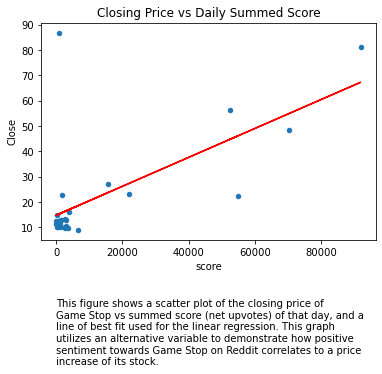

In [119]:
# Linear Regression - Score

# create a scatter plot of the data
mergedData2.plot(kind='scatter', x='score', y='Close')

# fit a linear regression model to the data
slope, intercept = np.polyfit(mergedData2['score'], mergedData2['Close'], 1)

# add a regression line to the scatter plot
plt.plot(mergedData2['score'], slope*mergedData2['score'] + intercept, color='red')

plt.title('Closing Price vs Daily Summed Score')

# add a description to the graph
description = textwrap.wrap("This figure shows a scatter plot of the closing price of Game Stop vs summed score (net upvotes) of that day, and a line of best fit used for the linear regression. This graph utilizes an alternative variable to demonstrate how positive sentiment towards Game Stop on Reddit correlates to a price increase of its stock.", width=60)

plt.text(-20, -45,'\n'.join(description), fontsize=10, ha='left', va='bottom')


plt.savefig('regression_plot2.jpeg',dpi=300, bbox_inches = "tight")

# show the plot
plt.show()

# Time Series Visualizations

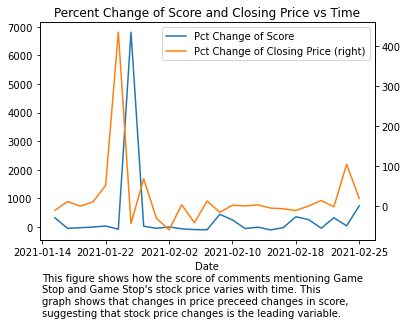

In [134]:
#For Score

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
mergedData2.plot(x = 'Date', y = 'Pct Change of Score', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
mergedData2.plot(x = 'Date', y = 'Pct Change of Closing Price', ax = ax, secondary_y = True) 
plt.title('Percent Change of Score and Closing Price vs Time')

# add a description to the graph
description = textwrap.wrap("This figure shows how the summed daily score of comments mentioning Game Stop and Game Stop's stock price varies with time. This graph shows that changes in price preceed changes in score, suggesting that stock price changes is the leading variable.", width=60)

plt.text(0, -280,'\n'.join(description), fontsize=10, ha='left', va='bottom')


# plt.text(0, 0, "This figure shows how the score of comments mentioning Game Stop and Game Stop's stock price varies with time. This graph shows that changes in price preceed changes in score, suggesting that stock price changes is the leading variable.", ha='left', va='bottom')

# ha='left', va='bottom')


plt.savefig('time_series_plot1.jpeg',dpi=300, bbox_inches = "tight")

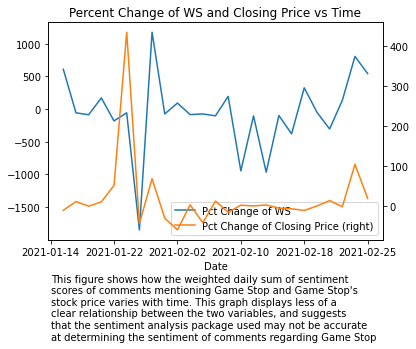

In [137]:
# For Weighted Sentiment

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
mergedData2.plot(x = 'Date', y = 'Pct Change of WS', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
mergedData2.plot(x = 'Date', y = 'Pct Change of Closing Price', ax = ax, secondary_y = True) 
plt.title('Percent Change of WS and Closing Price vs Time')

# add a description to the graph
description = textwrap.wrap("This figure shows how the weighted daily sum of sentiment scores of comments mentioning Game Stop and Game Stop's stock price varies with time. This graph displays less of a clear relationship between the two variables, and suggests that the sentiment analysis package used may not be accurate at determining the true sentiment of comments regarding Game Stop.", width=60)

plt.text(0, -340,'\n'.join(description), fontsize=10, ha='left', va='bottom')


plt.savefig('time_series_plot2.jpeg',dpi=300, bbox_inches = "tight")
